In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
import time

In [ ]:
events_list = []
headers = {"User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5)"}

months = ["janvier","fevrier","mars","avril","mai","juin","juillet","aout","septembre","octobre","novembre","decembre"]
years = [str(i) for i in range(2017,2022)]
for n,i  in enumerate(itertools.product(years,months)):
        year = i[0]
        month = i[1]
        
        r = requests.get(f"http://www.elysee.fr/agenda-{month}-{year}",headers=headers)
        print(month,year)
        print("status_code : ", r.status_code)
        bs = BeautifulSoup(r.content)
        days = bs.find_all("section",class_="container")
        days = [i for i in days if i.find("h3",class_="sticker__content")]
        
        for date in days:
            n_date = date.find("h3",{"class" : "sticker__content"}).find_all("span")[0].text

            for day in date.find_all("ul",class_="list-table"):
                for event in day.find_all("li"):
                    if event.find("p",class_="list-table__hour"):
                        hour = event.find("p",class_="list-table__hour").text
                        event_type = event.find("p",class_="list-table__type").text if event.find("p",class_="list-table__type") else None
                        description = event.find("p", class_="m-b-n").text if event.find("p", class_="m-b-n") else None
                        program = [i.text for i in event.find_all("a",class_="link") if i]

                        event_dic = {}
                        event_dic["date"] = n_date + " " + month + " " + year
                        event_dic["hour"] = hour
                        event_dic["event_type"] = event_type
                        event_dic["description"]= description
                        event_dic["program"] = program

                        events_list.append(event_dic)
        time.sleep(2)

In [13]:
df = pd.json_normalize(events_list)
dic_months = {
    "janvier" : "january",
    "fevrier" : "february",
    "mars" : "march",
    "avril" : "april",
    "mai" : "may",
    "juin" : "june",
    "juillet" : "july",
    "aout" : "august",
    "septembre" : "september",
    "octobre" : "october",
    "novembre" : "november",
    "decembre" : "december"
}

for old,new in dic_months.items():
    df["date"] = df['date'].str.replace(old,new)
df.to_csv("agenda_président.csv", index=False)
df["date"] =  pd.to_datetime(df["date"])

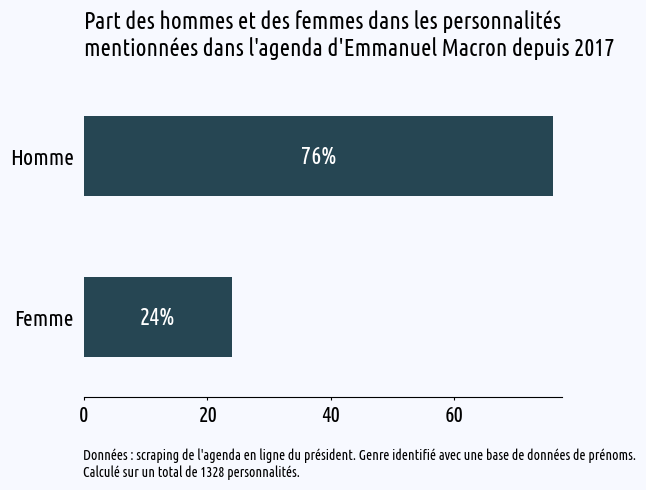

In [56]:
data = pd.read_csv("/home/riri/Documents/projects/agenda président/agenda_président.csv")


female = data["description"].str.extractall("( Mme )")[0].reset_index(drop=True)
male = data["description"].str.extractall("( M\. )")[0].reset_index(drop=True)
gender = pd.concat([female,male])
share = gender.value_counts(normalize=True).multiply(100).round()

x = ["Homme","Femme"]
y = list(share)
d = pd.DataFrame(y,x)[0]

with plt.style.context("rirO"):
    plt.figure(figsize=(6.5,5))
    d.plot(kind='barh')
    plt.gca().invert_yaxis()
    for value, n in zip(d.values,[0,1]):
        plt.text(value/2,n,str(round(value,0))[:2] + "%", ha="center",color='white',fontsize=17,va="center")
        
    plt.title("Part des hommes et des femmes dans les personnalités\nmentionnées dans l'agenda d'Emmanuel Macron depuis 2017")
    
    plt.text(-0.07,2, "Données : scraping de l'agenda en ligne du président. Genre identifié avec une base de données de prénoms.\nCalculé sur un total de {} personnalités.".format(len(gender)))
    
    plt.tight_layout()
    plt.savefig("macron_femmes.png",dpi=150)
    plt.show()